# Семинар - Self-Supervision

# Imports

```pythin
!pip install albumentations

```

## <font color='orange'>Imports</font>

In [7]:
import random
from pathlib import Path
from time import gmtime, strftime

import yaml
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

from sklearn.manifold import TSNE

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [9]:
# fix all seeds
seed = 42

set_seed(seed)

In [10]:
torch.backends.mps.is_available()

True

# SimCLR - A Simple Framework for Contrastive Learning of Visual Representations

За последние несколько лет мы стали свидетелями огромного прогресса в обучении с самоконтролем специально для задач, связанных с компьютерным зрением. В то время как область обработки естественного языка извлекала выгоду из достоинств обучения с самоконтролем в течение долгого времени, но это было не так давно, системы компьютерного зрения начали видеть реальное влияние парадигм обучения с самоконтролем. Такие работы, как [MoCo](https://arxiv.org/abs/1911.05722), [PIRL](https://arxiv.org/abs/1912.01991) продемонстрировали, какие преимущества системы с самоконтролем могут принести для решения проблем, связанных с компьютерным зрением.

Chen at al. выпустили работу [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf) (SimCLR), в которой представлена более простая, но эффективная структура для обучения моделей на основе компьютерного зрения с самоконтролем.

<img src="https://camo.githubusercontent.com/5ab5e0c019cdd8129b4450539231f34dc028c0cd64ba5d50db510d1ba2184160/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966" alt="Drawing" style="width: 400px;"/>

Оффициальный [репозиторий](https://github.com/google-research/simclr)

[Статья](https://arxiv.org/abs/2011.02803)

## Идея самообучения (Self-Supervision) в компьютерном зрении

Для обучения моделей Self-Supervision с полностью неразмеченными данными необходимо сначала сформулировать контролируемую задачу обучения (также известную как предварительное текстовое задание) с этими неразмеченными данными. Например, для обучения встраиванию слов в большой корпус, такой как Википедия, вы можете решить задачу предсказания следующего слова по заданной последовательности слов. Итак, как вы могли бы расширить эту идею, когда дело доходит до работы с немаркированными изображениями?

Важно отметить, что задача контрастного прогнозирования не должна быть ни слишком простой, ни сложной, и она должна помочь модели развить понимание заданных данных (подумайте о том, как встраивания фиксируют семантические отношения между связанными словами).

Вы можете узнать больше об этом из следующей статьи [Self-supervised learning and computer vision](https://www.fast.ai/2020/01/13/self_supervised/).

# Data

## Загрузка данных CIFAR10

In [12]:
from cifar import load_cifar10

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../../07_CNN/seminar/cifar_data", channels_last=True)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)


## Аугментации с библиотекой ```albumentations```

Albumentations — это быстрая и гибкая библиотека для увеличения изображений. Библиотека широко используется в промышленности, исследованиях глубокого обучения, конкурсах по машинному обучению и проектах с открытым исходным кодом. Альбументации написаны на Python и распространяются под лицензией MIT. Исходный код доступен по адресу https://github.com/albumentations-team/albumentations.

Гайды доступны на странице [Introduction to image augmentation](https://albumentations.ai/docs/#introduction-to-image-augmentation).

In [33]:
import albumentations as A

In [34]:
# вспомогательная функция
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [35]:
# порядок функций аугментации
transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90()
])

In [36]:
# выберем случайное изображение
idx = np.random.choice(tuple(range(len(X_train))), 1)[0]

sample_image = (X_train[idx] * 255).astype(np.uint8)

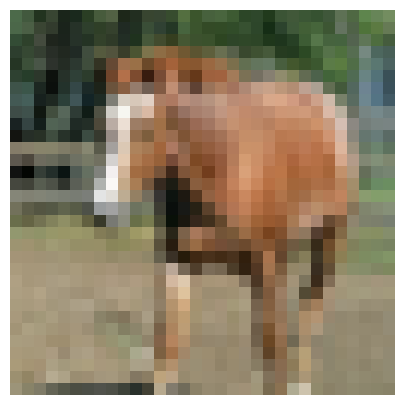

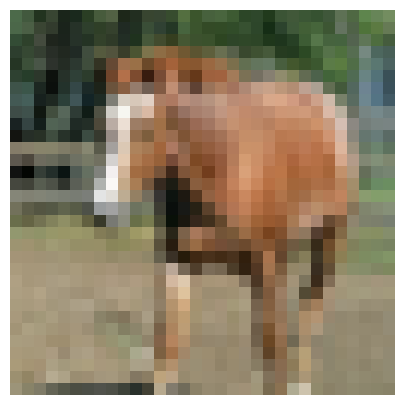

In [37]:
augmented_image = transform(image=sample_image)['image']
visualize(augmented_image)
visualize(sample_image)

In [85]:
transform = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.Transpose(),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

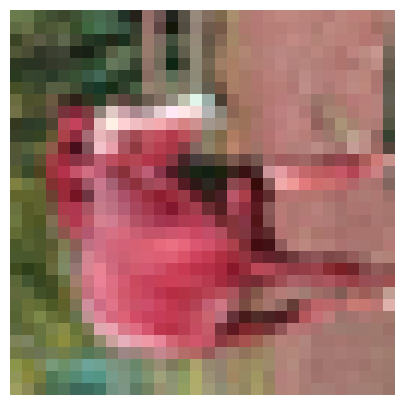

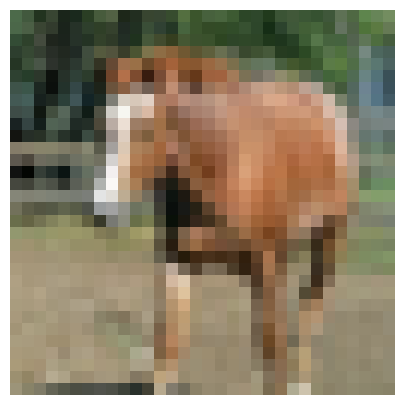

In [109]:
augmented_image = transform(image=sample_image)['image']
visualize(augmented_image)
visualize(sample_image)

## Data Generator for Contrastive Learning

В оригинальной статье предложен следующий подход к аугментации данных, приведенный на рисунке ниже.

![transforms](https://i.ibb.co/7JFG4pf/image.png)

### Задание № 1
Ваша задача создать ```Dataset```, который использует функции аугментаций на основе библиотеки ```albumentations```

### Dataset & Data Generator

In [111]:
class CLDataset(Dataset):
    def __init__(self, x_data, y_data, transform_augment=None):
        self.x_data = x_data
        self.y_data = y_data

        assert transform_augment is not None, 'set transform_augment'
        # TODO: pass your code
        self.transform_augment = transform_augment

    def __len__(self):
        # TODO: pass your code
        return len(self.x_data)

    def __getitem__(self, item):
        image = self.x_data[item]
        image = (image * 255).astype(np.uint8)
        label = self.y_data[item]

        # TODO: pass your code
        x1 = self.transform_augment(image=image)['image']
        x2 = self.transform_augment(image=image)['image']

        image = torch.tensor(image).permute(2, 0, 1)

        return x1, x2, label, image

### Задание № 2

Расчитайте среднее значение и дисперсию для функции нормализации

In [113]:
# TODO: pass your code
MEAN = np.mean(X_train, axis=(0, 1, 2), keepdims=True).squeeze()
STD = np.std(X_train, axis=(0, 1, 2), keepdims=True).squeeze()

### Задание № 3

Задайте преобразования для шага обучения и шага валидации. На валидации не должно быть преобразований, изменяющих исходные данные.

In [117]:
# TODO: pass your code

train_transform = A.Compose([
    transform,
#     A.OneOf([
#         A.ColorJitter(),
#         A.ToGray(),
# #         A.GaussNoise(),
#     ]),
# #     A.OneOf([
# #         A.Cutout(num_holes=1, max_h_size=10, max_w_size=10),
# #         A.RandomResizedCrop(32, 32),
# #         A.GaussianBlur(),
# #     ]),
#     A.HorizontalFlip(),
# #     A.RandomRotate90(),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

In [118]:
train_dataset = CLDataset(X_train, y_train, transform_augment=train_transform)
valid_dataset = CLDataset(X_val, y_val, transform_augment=valid_transform)

In [119]:
batch_size = 32
n_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=n_workers)

val_loader = torch.utils.data.DataLoader(valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=n_workers)

### Проверка итераций загрузчика данных

In [123]:
x1, x2, _, _ = next(iter(train_loader))
print(x1.shape, x2.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 32, 32])


In [132]:
def plot_batch(x, STD, MEAN):
    plt.figure(figsize=[12, 10])
    plt.axis('off')

    grid = torchvision.utils.make_grid(x, 8, )
    grid = grid.numpy().transpose((1, 2, 0))
    grid = grid * STD + MEAN
    plt.imshow(grid)

    plt.tight_layout()

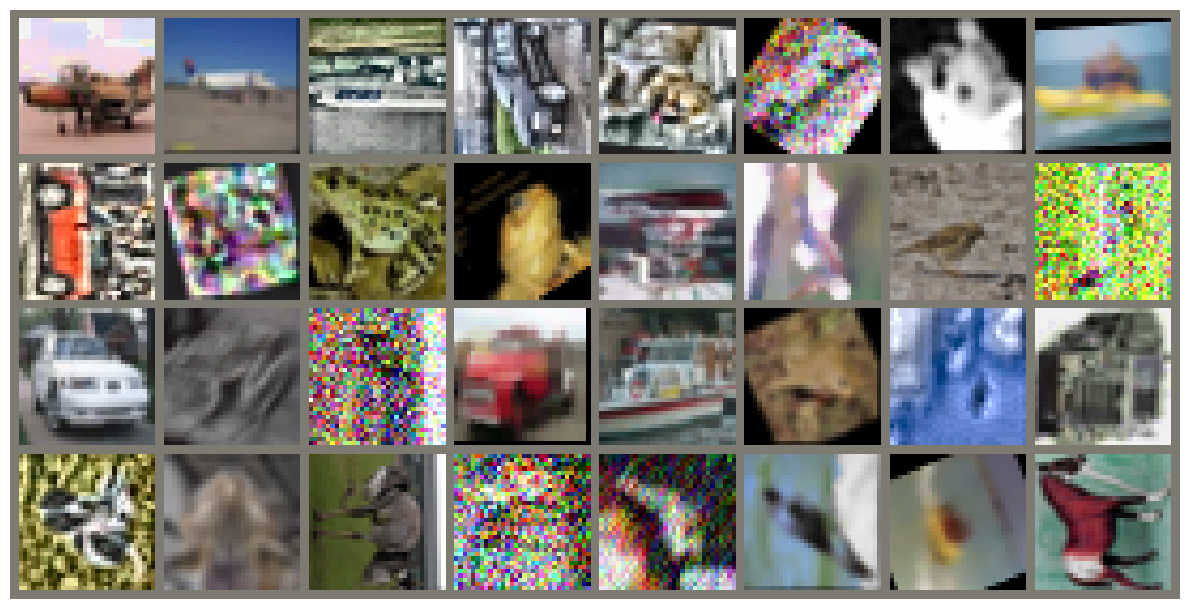

In [133]:
plot_batch(x1, STD, MEAN)

In [134]:
def get_cropped_data_idxs(data, crop_coef: float = 1.0):
    crop_coef = np.clip(crop_coef, 0, 1)

    init_data_size = len(data)
    final_data_size = int(init_data_size * crop_coef)

    random_idxs = np.random.choice(tuple(range(init_data_size)), final_data_size, replace=False)
    return random_idxs

In [135]:
def load_datasets(X_train, y_train, X_val, y_val, crop_coef=0.2):
    train_idxs = get_cropped_data_idxs(X_train, crop_coef=crop_coef)
    train_data = X_train[train_idxs]
    train_labels = y_train[train_idxs]

    valid_idxs = get_cropped_data_idxs(X_val, crop_coef=crop_coef)
    valid_data = X_val[valid_idxs]
    valid_labels = y_val[valid_idxs]

    train_dataset = CLDataset(train_data, train_labels, transform_augment=train_transform)
    valid_dataset = CLDataset(valid_data, valid_labels, transform_augment=valid_transform)

    return train_dataset, valid_dataset

In [136]:
train_dataset, valid_dataset = load_datasets(X_train, y_train, X_val, y_val, crop_coef=1.4)
print('Train size:', len(train_dataset), 'Valid size:', len(valid_dataset))

Train size: 40000 Valid size: 10000


In [137]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True
                         )

In [138]:
x1, x2, _, ori = next(iter(train_loader))
x1.shape

/Users/nikolayborovets/Desktop/FALT_MIPT/ML/ml_mipt_dafe/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 3, 32, 32])

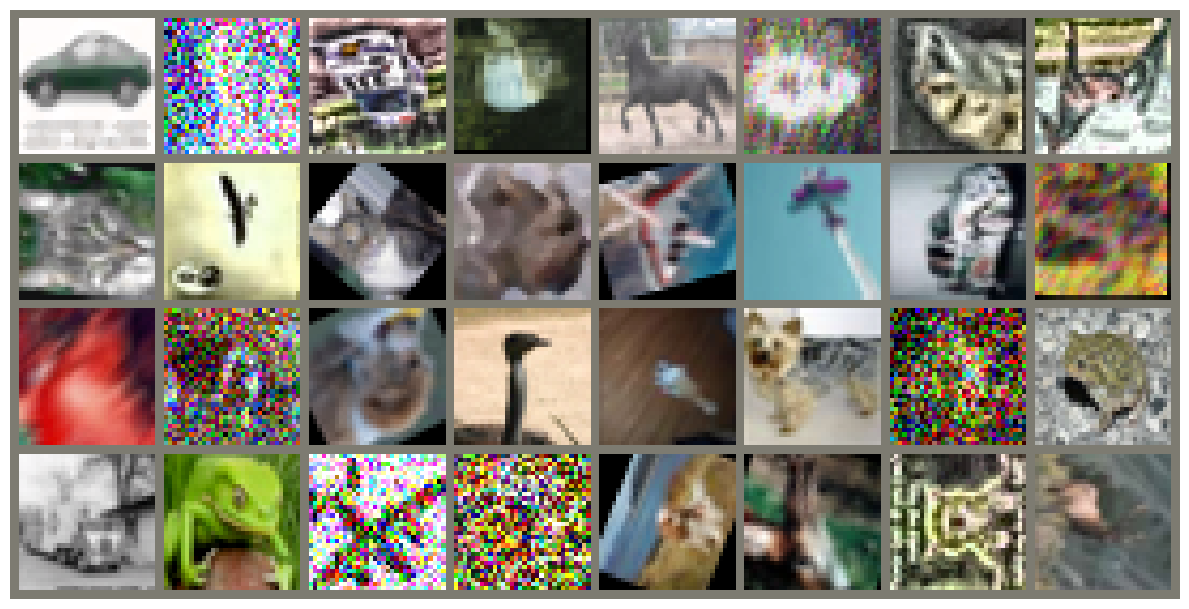

In [139]:
plot_batch(x1, STD, MEAN)

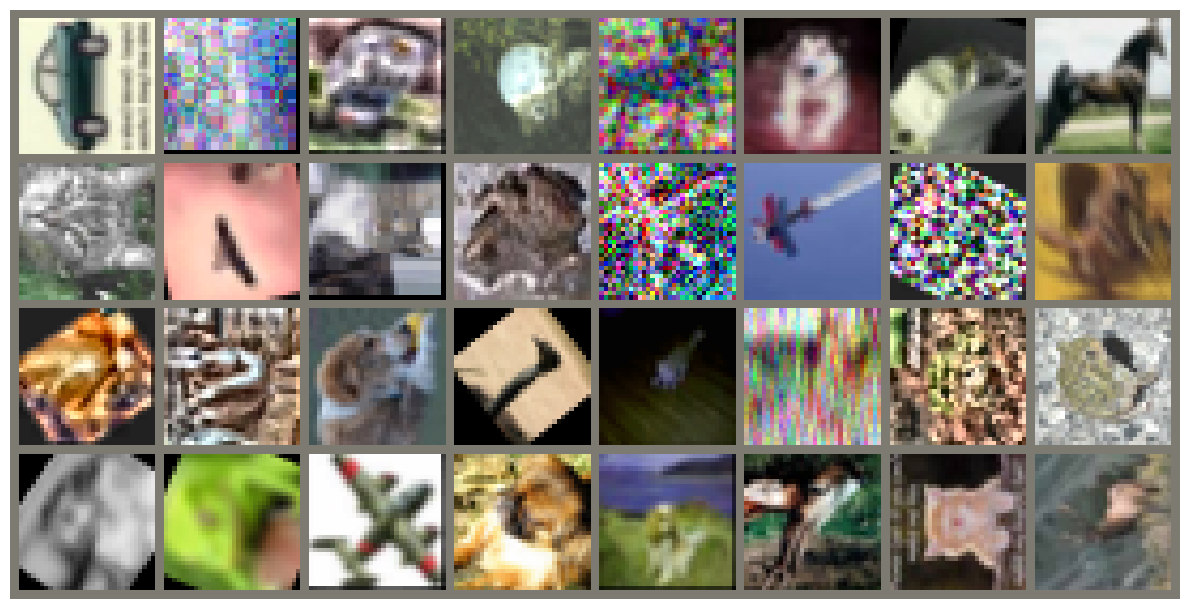

In [140]:
plot_batch(x2, STD, MEAN)

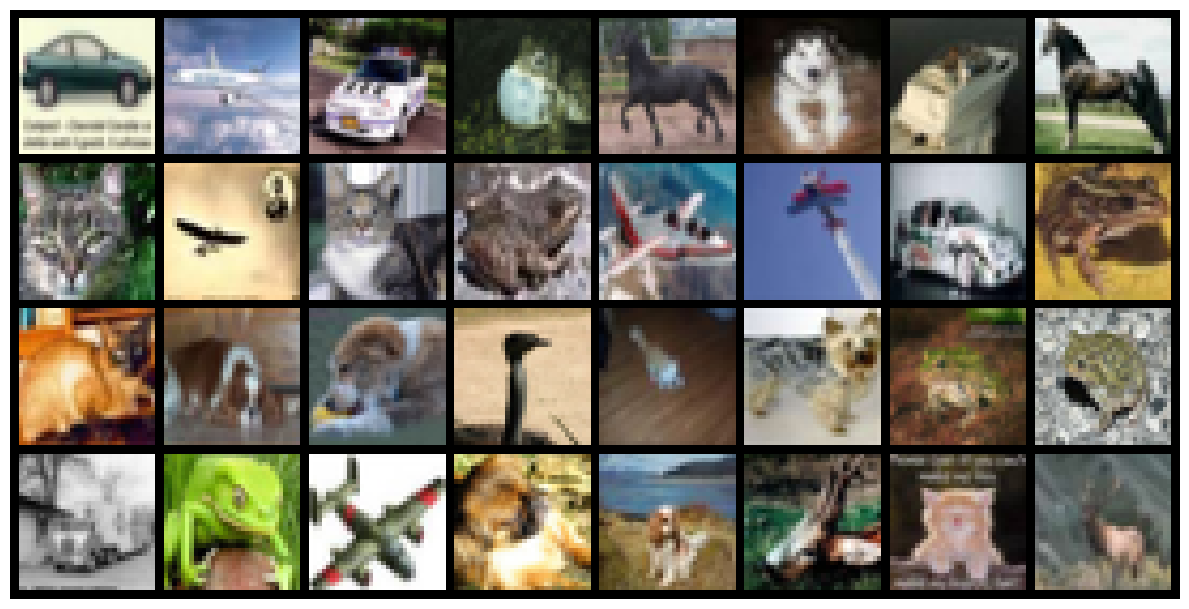

In [149]:
plot_batch(ori, 1, 0)

# Построение модели

Используя описанный алгоритм загрузки данных, теперь мы можем реализовать SimCLR. На каждой итерации мы получаем для каждого изображения две по-разному дополненные версии, которые мы обозначаем как и.

Оба этих изображения закодированы в одномерный вектор признаков, между которыми мы хотим добиться максимального сходства, что сводит его к минимуму по отношению ко всем другим изображениям в пакете. Сеть кодировщика разделена на две части: базовую сеть кодировщика и проекционную головку .

Базовая сеть обычно представляет собой глубокую CNN и отвечает за извлечение вектора представления из примеров дополненных данных. В наших экспериментах мы будем использовать общую архитектуру ResNet-18.
Проекционная голова (MLP) отображает представление в пространство, где мы применяем контрастивную ошибку, т.е. сравниваем сходства между векторами.
Часто выбирается небольшой MLP с нелинейностями, и для простоты мы следуем оригинальной настройке SimCLR, определяя его как двухслойный MLP с активацией ReLU в скрытом слое. Обратите внимание, что в последующей статье, SimCLRv2, авторы упоминают, что большие / более широкие MLP могут значительно повысить производительность. Вот почему мы применяем MLP с вчетверо большими скрытыми измерениями, но более глубокие MLP показали, что они превосходят данный набор данных. Общая настройка визуализирована ниже:

![](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/simclr_network_setup.svg)


In [151]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [152]:
class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super().__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features,
                                self.out_features,
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

In [159]:
def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super().__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features, self.out_features, use_bias=False, use_bn=True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features, self.hidden_features, use_bias=True, use_bn=True),
                nn.ReLU(),
                LinearLayer(self.hidden_features, self.out_features, use_bias=False, use_bn=True))

    def forward(self,x):
        x = l2_norm(x)
        x = self.layers(x)
        return x


class PreModel(nn.Module):
    def __init__(self):
        super().__init__()

        # pretrained model
        model = torchvision.models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*tuple(model.children())[:-1])

        emb_size = tuple(model.children())[-1].in_features

        for p in self.encoder.parameters():
            p.requires_grad = False

        self.projector = ProjectionHead(emb_size, 2048, 128)

    def forward(self,x):
        out = self.encoder(x)

        xp = self.projector(torch.squeeze(out))

        return xp

In [160]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [161]:
device = 'cpu'
model = PreModel()
model = model.to(device)

In [165]:
x = np.random.random((32,3,224,224))

In [166]:
out = model(torch.tensor(x, device=device, dtype=torch.float32))

In [167]:
out.shape

torch.Size([32, 128])

# Обучение модели

## Функция ошибки

Normalized Temperature-Scaled Cross-Entropy Loss (NT-XEnt loss)

Теперь, когда архитектура описана, давайте подробнее рассмотрим, как мы обучаем модель. Как упоминалось ранее, мы хотим максимизировать сходство между представлениями двух дополненных версий одного и того же изображения на рисунке выше, сводя его к минимуму для всех других примеров в пакете. Короче говоря, функция ошибки сравнивает сходство $z_i$ и $z_j$
к любому другому представлению в пакете, выполнив softmax над значениями подобия. Ошибка может быть формально записана как:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

где
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$


In [168]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()

        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        # SIMCLR
        labels = torch.from_numpy(np.array([0] * N)).reshape(-1).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [169]:
x1 = torch.tensor(np.random.random((4, 128)))
x2 = torch.tensor(np.random.random((4, 128)))

loss = SimCLR_Loss(batch_size=4, temperature=0.2).to(device)
loss(x1, x2)

tensor(1.9863, dtype=torch.float64)

## Optimizer

### LARS

Обычный способ ускорить обучение больших сверточных сетей — добавить вычислительные единицы. Затем обучение выполняется с использованием параллельных синхронных данных. С увеличением количества ГПУ увеличивается размер пакета (batch size). Но обучение с большим размером партии часто приводит к снижению точности модели. Авторы публикации [LARS](https://arxiv.org/pdf/1708.03888.pdf) предлагают способ, как этого можно избежать.

Реализация [LARS](https://github.com/Spijkervet/SimCLR/blob/cd85c4366d2e6ac1b0a16798b76ac0a2c8a94e58/simclr/modules/lars.py) для ```pytorch```.

Однако для упрощения примера мы рассмотрим обучение через Adam.

## Визуализация эмбедингов

In [170]:
def plot_features(model, dataloader, device='cpu'):
    feats = []
    labels = []
    model.eval()

    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader), desc='collect feats')
        for x1, x2, label, _ in pbar:
            x1 = x1.to(device)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats.append(out)
            labels.append(label.cpu().data.numpy())

    feats = np.concatenate(feats)
    labels = np.concatenate(labels)

    print('Train TSNE ...')
    tsne = TSNE(n_components=2, perplexity=50, verbose=0, n_jobs=4)
    x_feats = tsne.fit_transform(feats)

    print('Plot labels ...')
    num_classes = len(np.unique(labels))
    fig = plt.figure(figsize=(6.4 * 2, 4.8 * 1))

    for i in range(num_classes):
        label_idxs = np.argwhere(labels == i)
        plt.scatter(x_feats[label_idxs, 1],x_feats[label_idxs, 0])

    plt.legend([str(i) for i in range(num_classes)])
    plt.axis('off')
    plt.margins(0)
    plt.tight_layout()
    plt.close()
    return fig

In [171]:
model = PreModel()
fig = plot_features(model, val_loader)

collect feats: 100%|██████████| 313/313 [05:45<00:00,  1.10s/it]


Train TSNE ...
Plot labels ...


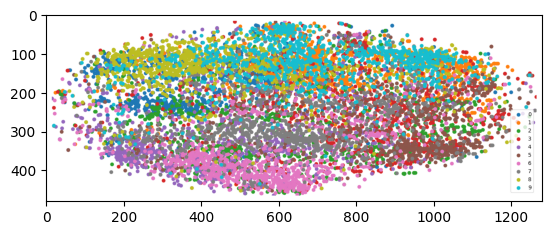

In [172]:
fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))

image_from_plot = image_from_plot[..., :3]

plt.imshow(image_from_plot);

## Класс обучения

In [173]:
class BaseTrainProcess:
    def __init__(self, hyp):
        start_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())
        log_dir = (Path("logs") / start_time).as_posix()
        print('Log dir:', log_dir)
        self.writer = SummaryWriter(log_dir)

        self.best_loss = 1e100
        self.best_acc = 0.0
        self.current_epoch = -1
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.hyp = hyp

        self.lr_scheduler: Optional[torch.optim.lr_scheduler] = None
        self.model: Optional[torch.nn.modules] = None
        self.optimizer: Optional[torch.optim] = None
        self.criterion: Optional[torch.nn.modules] = None

        self.train_loader: Optional[Dataloader] = None
        self.valid_loader: Optional[Dataloader] = None

        self.init_params()

    def _init_data(self):

        train_dataset, valid_dataset = load_datasets(X_train, y_train, X_val, y_val, crop_coef=1.4)
        print('Train size:', len(train_dataset), 'Valid size:', len(valid_dataset))

        self.train_loader = DataLoader(train_dataset,
                                       batch_size=self.hyp['batch_size'],
                                       shuffle=True,
                                       num_workers=self.hyp['n_workers'],
                                       pin_memory=True,
                                       drop_last=True
                                      )

        self.valid_loader = DataLoader(valid_dataset,
                                       batch_size=self.hyp['batch_size'],
                                       shuffle=True,
                                       num_workers=self.hyp['n_workers'],
                                       pin_memory=True,
                                       drop_last=True
                                      )

    def _init_model(self):
        self.model = PreModel()
        self.model.to(self.device)

        model_params = [params for params in self.model.parameters() if params.requires_grad]
        # self.optimizer = LARS(model_params, lr=0.2, weight_decay=1e-4)
        self.optimizer = torch.optim.AdamW(model_params, lr=self.hyp['lr'], weight_decay=self.hyp['weight_decay'])

        # "decay the learning rate with the cosine decay schedule without restarts"
        self.warmupscheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambda epoch: (epoch + 1) / 10.0)
        self.mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            500,
            eta_min=0.05,
            last_epoch=-1,
        )

        self.criterion = SimCLR_Loss(batch_size=self.hyp['batch_size'],
                                     temperature=self.hyp['temperature']).to(self.device)

    def init_params(self):
        self._init_data()
        self._init_model()

    def save_checkpoint(self, loss_valid, path):
        if loss_valid[0] <= self.best_loss:
            self.best_loss = loss_valid[0]
            self.save_model(path)

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.mainscheduler.state_dict()
        }, path)

    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        self.model.zero_grad()

        cum_loss = 0.0
        proc_loss = 0.0

        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader),
                    desc=f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (xi, xj, _, _) in pbar:
            xi, xj = xi.to(self.device), xj.to(self.device)

            with torch.set_grad_enabled(True):
                zi = self.model(xi)
                zj = self.model(xj)
                loss = self.criterion(zi, zj)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.model.zero_grad()

            cur_loss = loss.detach().cpu().numpy()
            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            s = f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}'
            pbar.set_description(s)

        cum_loss /= len(self.train_loader)
        return [cum_loss]

    def valid_step(self):
        self.model.eval()

        cum_loss = 0.0
        proc_loss = 0.0

        pbar = tqdm(enumerate(self.valid_loader), total=len(self.valid_loader),
                    desc=f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (xi, xj, _, _) in pbar:
            xi, xj = xi.to(self.device), xj.to(self.device)

            with torch.set_grad_enabled(False):
                zi = self.model(xi)
                zj = self.model(xj)
                loss = self.criterion(zi, zj)

            cur_loss = loss.detach().cpu().numpy()
            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            s = f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}'
            pbar.set_description(s)

        cum_loss /= len(self.valid_loader)
        return [cum_loss]

    def run(self):
        best_w_path = 'best.pt'
        last_w_path = 'last.pt'

        train_losses = []
        valid_losses = []

        for epoch in range(self.hyp['epochs']):
            self.current_epoch = epoch

            loss_train = self.train_step()
            train_losses.append(loss_train)

            if epoch < 10:
                self.warmupscheduler.step()
            else:
                self.mainscheduler.step()

            lr = self.optimizer.param_groups[0]["lr"]

            loss_valid = self.valid_step()
            valid_losses.append(loss_valid)

            self.save_checkpoint(loss_valid, best_w_path)

            self.writer.add_scalar('Train/Loss', loss_train[0], epoch)
            self.writer.add_scalar('Valid/Loss', loss_valid[0], epoch)
            self.writer.add_scalar('Lr', lr, epoch)

            if (epoch + 1) % 10 == 0 or epoch == self.hyp['epochs'] - 1:
                fig = plot_features(self.model, self.valid_loader, device=self.device)
                fig.canvas.draw()
                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                self.writer.add_image('TSNE val embedings', image_from_plot, epoch, dataformats='HWC')

        self.save_model(last_w_path)
        torch.cuda.empty_cache()
        self.writer.close()

        return train_losses, valid_losses

In [174]:
with open('hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

print(hyps)

{'batch_size': 128, 'lr': 0.2, 'lrf': 0.02, 'epochs': 50, 'weight_decay': 0.0004, 'n_workers': 0, 'temperature': 0.5, 'seed': 42}


In [175]:
set_seed(hyps['seed'])

trainer = BaseTrainProcess(hyps)
trainer.device = 'cpu'
trainer.init_params()

Log dir: logs/2025-06-05 10-21-21
Train size: 40000 Valid size: 10000


/Users/nikolayborovets/Desktop/FALT_MIPT/ML/ml_mipt_dafe/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nikolayborovets/Desktop/FALT_MIPT/ML/ml_mipt_dafe/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train size: 40000 Valid size: 10000


In [176]:
train_losses, valid_losses = trainer.run()

/Users/nikolayborovets/Desktop/FALT_MIPT/ML/ml_mipt_dafe/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train 0/49, Loss: 5.305:   2%|▏         | 5/312 [00:37<38:31,  7.53s/it]


KeyboardInterrupt: 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs --port 6006

# Литература и ссылки
- Документация [Albumentations](https://albumentations.ai/)
- Предобученные модели [torchvision](https://pytorch.org/vision/stable/models.html)
- [LARGE BATCH TRAINING OF CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1708.03888.pdf)
- [SimCLR](https://arxiv.org/pdf/2002.05709.pdf)
- [Self-supervised learning and computer vision](https://www.fast.ai/2020/01/13/self_supervised/)
- [Pytorch SimCLR](https://github.com/sthalles/SimCLR)